# ***Breakout with DQN***

Atari Breakout environment.
* Loosely based on the [Gymnax](https://github.com/RobertTLange/gymnax/blob/main/gymnax/environments/minatar/breakout.py) version:
* [Original MinAtar implementation](https://github.com/kenjyoung/MinAtar/blob/master/minatar/environments/breakout.py)
    

## ***State description:***
| Name       | Type          | Description                                                                                     |
|------------|---------------|-------------------------------------------------------------------------------------------------|
| ball_x     | int           | x-axis position of the ball, range: 0-9                                                        |
| last_y     | int           | y-axis position of the ball at the last timestep, range: 0-9                                   |
| ball_dir   | int           | direction of the ball: <br>0: Up and to the left<br>1: Up and to the right<br>2: Down and to the right<br>3: Down and to the left |
| pos        | int           | x-axis position of the player's paddle, range: 0-9                                             |
| brick_map  | jnp.ndarray   | array representation of the brick layers, three layers are initially present, from rows 2 to 4 |
| strike     | bool          | whether the ball has hit a brick at the current timestep                                       |
| time       | int           | current timestep                                                                               |
| done       | bool          | done flag                                                                                      |

## ***DQN Architecture Details***

### **Convolutional Layer**
  - **Type:** Convolutional 2D Layer
  - **Parameters:**
    - `output_channels`: 16
    - `kernel_shape`: 3
    - `stride`: 1
  - **Activation Function:** ReLU (applied after convolutional layer)


### **Fully Connected Layer (MLP)**
  - **Type:** Multi-Layer Perceptron (MLP)
  - **Parameters:**
    - `output_sizes`: [128, `env.n_actions`]
    - `activation`: ReLU
    - `activate_final`: False
  - **Input Transformation:** Input is reshaped to a 1D array before being passed to the MLP

<br>

<div align="center">
    <img src="https://gymnasium.farama.org/_images/breakout.gif" height=400>
</div>

## ***References***:
* [Minatar](https://github.com/kenjyoung/MinAtar/blob/master/minatar/environments/breakout.py)
* [Gymnax](https://github.com/RobertTLange/gymnax/blob/main/gymnax/environments/minatar/breakout.py)
* [Gymnasium](https://gymnasium.farama.org/environments/atari/breakout/)

In [1]:
import sys
import jax
import jax.numpy as jnp
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import optax
import haiku as hk
import plotly.graph_objects as go
import numpy as np

from jax import random, vmap, lax
from jax_tqdm import loop_tqdm

sys.path.append("../../")
from src import Breakout, DQN, UniformReplayBuffer, minatar_rollout

c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\jax-rl-KPtyfD6I-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ***Hyperparameters***

References:
* [*Dopamine: A Research Framework for Reinforcement Learning*](https://arxiv.org/pdf/1812.06110.pdf)
* [*Large Batch Experiences Replay*](https://arxiv.org/pdf/2110.01528.pdf)

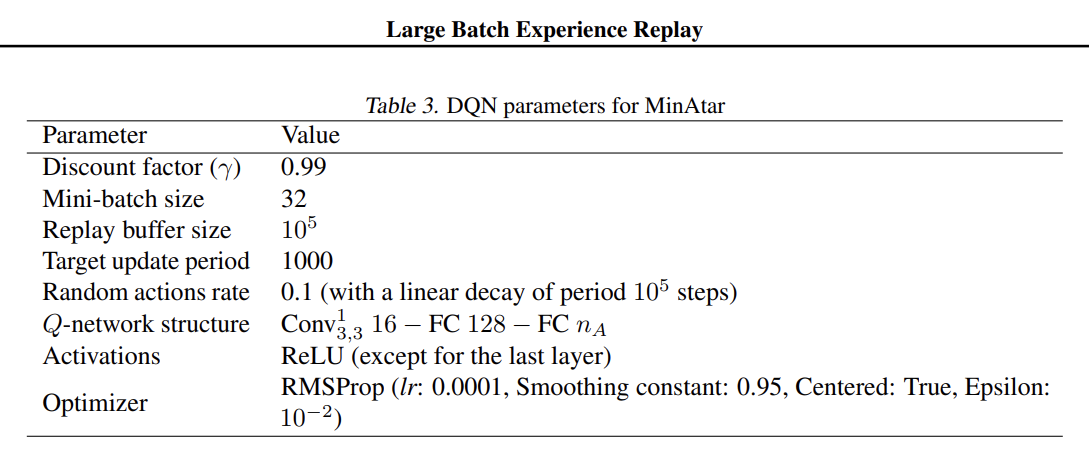

In [2]:
# MinAtar Breakout params
DISCOUNT = 0.99
BATCH_SIZE = 32
BUFFER_SIZE = 100_000
TARGET_NET_UPDATE_FREQ = 1000


# other params
RANDOM_SEED = 0
STATE_SHAPE = (10, 10, 4)
N_ACTIONS = 3

CONV_LAYER_PARAMS = {
    "output_channels": 16,
    "kernel_shape": 3,
    "stride": 1,
}
MLP_PARAMS = {
    "output_sizes": [128, N_ACTIONS],
    "activation": jax.nn.relu,
    "activate_final": False,
}
OPTIMIZER_PARAMS = {
    "learning_rate": 1e-4,
    "decay": 0.95,  # named `smoothing constant` in the paper
    "centered": True,
    "eps": 10e-2,
}
EPSILON_DECAY_PARAMS = {
    "epsilon_start": 0.1,
    "epsilon_end": 0,
    "decay_period": 100_000,
}

In [3]:
key = random.PRNGKey(0)
env = Breakout()


@hk.transform
def model(x):
    """
    MinAtar version of DQN
    ref: https://github.com/kenjyoung/MinAtar/blob/master/examples/dqn.py
    """
    conv_layer = hk.Conv2D(**CONV_LAYER_PARAMS)
    fc = hk.nets.MLP(**MLP_PARAMS)

    x = jax.nn.relu(conv_layer(x))
    x = x.reshape(-1)
    return fc(x)

def linear_decay(
    epsilon_start: float,
    epsilon_end: float,
    current_step: int,
    decay_period: int,
) -> float:
    decay_rate = (epsilon_start - epsilon_end) / decay_period
    new_epsilon = epsilon_start - current_step * decay_rate
    return jnp.maximum(jnp.float32(epsilon_end), new_epsilon)


replay_buffer = UniformReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
online_key, target_key = vmap(random.PRNGKey)(jnp.arange(2) + RANDOM_SEED)

online_net_params = model.init(online_key, random.normal(online_key, env.obs_shape))
target_net_params = model.init(target_key, random.normal(target_key, env.obs_shape))

optimizer = optax.rmsprop(**OPTIMIZER_PARAMS)
optimizer_state = optimizer.init(online_net_params)

agent = DQN(model, DISCOUNT, len(env.actions))

jax.tree_map(lambda x: x.shape, online_net_params)

{'conv2_d': {'b': (16,), 'w': (3, 3, 4, 16)},
 'mlp/~/linear_0': {'b': (128,), 'w': (1600, 128)},
 'mlp/~/linear_1': {'b': (3,), 'w': (128, 3)}}

In [4]:
buffer_state = {
    "states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "actions": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "rewards": jnp.empty((BUFFER_SIZE,), dtype=jnp.int32),
    "next_states": jnp.empty((BUFFER_SIZE, *STATE_SHAPE), dtype=jnp.float32),
    "dones": jnp.empty((BUFFER_SIZE,), dtype=jnp.bool_),
}
jax.tree_map(lambda x: x.shape, buffer_state)

{'actions': (100000,),
 'dones': (100000,),
 'next_states': (100000, 10, 10, 4),
 'rewards': (100000,),
 'states': (100000, 10, 10, 4)}

In [11]:
rollout_params = {
    "timesteps": 100_000,
    "random_seed": RANDOM_SEED,
    "target_net_update_freq": TARGET_NET_UPDATE_FREQ,
    "model": model,
    "optimizer": optimizer,
    "buffer_state": buffer_state,
    "agent": agent,
    "env": env,
    "replay_buffer": replay_buffer,
    "state_shape": STATE_SHAPE,
    "buffer_size": BUFFER_SIZE,
    "epsilon_decay_fn": linear_decay,
    "decay_params": EPSILON_DECAY_PARAMS,
}

out = minatar_rollout(**rollout_params)

c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\jax-rl-KPtyfD6I-py3.10\lib\site-packages\jax\_src\ops\scatter.py:94: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.

c:\Users\ryanp\AppData\Local\pypoetry\Cache\virtualenvs\jax-rl-KPtyfD6I-py3.10\lib\site-packages\jax\_src\ops\scatter.py:94: FutureWarning:

scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.

Running for 100,000 iterations: 100%|██████████| 100000/100000 [03:32<00:00, 470.97it/s]


In [12]:
out['all_done'].sum()

Array(100, dtype=int32)

In [13]:
px.line(out["losses"], title="Loss during training")

In [14]:
df = pd.DataFrame(
    data={
        "episode": out["all_done"].cumsum(),
        "reward": out["all_rewards"],
    },
)
df["episode"] = df["episode"].shift().fillna(0)
episodes_df = df.groupby("episode").agg("sum")

px.bar(episodes_df, y="reward", title=f"Performances of DQN on the Breakout Environment", )